# Branches

Branch pipelines are **linear secondary pipelines** that origin either from the primary dataframe or from a dataframe fetched from the Nebula Storage.

The input dataframe and the way that they are merged back (if requested) to the main flow depends on the “branch” configuration.

**The main flow/dataframe remains unchanged.**

In [1]:
import yaml

from nebula.spark_transformers import *
from nebula.base import Transformer
from nebula.pipelines.pipelines import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline
from nebula.storage import nebula_storage as ns

To create a **branch** in a pipeline, you’ll need to define a **dictionary** that specifies the input and how to merge it back into the main pipeline. 

Let’s break it down!

### **Input** Definition:<br>
- If the key `storage` is defined, the input for the branch will be the value associated with this key.<br>
- If “storage” is not defined, the input will be a copy of the primary dataframe. The original dataframe will remain untouched.

![title](branch_df_input.jpg)

### **Output** Definition:<br>
At the end of the pipeline, there are three possible scenarios based on the `end` value:
- `"end": "dead-end"`: the dataframe will not be merged back.<br>
- `"end": "append"`: the dataframe will be appended to the main one.<br>
- `"end": "append", "on": ..., "how": ...`the dataframe will be joined to the primary one using the provided `on` and `how` parameters.

![title](branch_df_output.jpg)

### Let's see all the possible combinations!

- **Input:** from storage
- **Output:** dead-end

*** TransformerPipeline *** (4 transformers)
 - Distinct
------ BRANCH ------ {'end': 'dead-end'}
    Input storage key: df_x
    *** TransformerPipeline *** (1 transformers)
     - WithColumn -> PARAMS: column_name="new", value=-1
       --> Store the dataframe with the key "df_fork"
 - Persist
 - Count


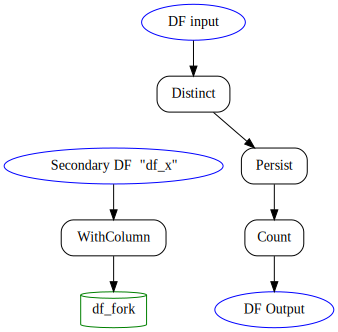

In [2]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "dead-end"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1
      - store: "df_fork"

  - transformer: Persist
  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** dead-end

*** TransformerPipeline *** (3 transformers)
 - Distinct
------ BRANCH ------ {'end': 'dead-end'}
    *** TransformerPipeline *** (1 transformers)
     - WithColumn -> PARAMS: column_name="new", value=-1
       --> Store the dataframe with the key "df_fork"
*** TransformerPipeline *** (1 transformers)
 - Count


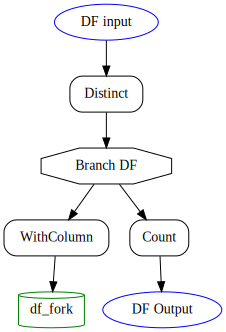

In [3]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "end": "dead-end"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1
      - store: "df_fork"

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** append

*** TransformerPipeline *** (3 transformers)
*** TransformerPipeline *** (1 transformers)
 - Distinct
------ BRANCH ------ {'end': 'append'}
    *** TransformerPipeline *** (1 transformers)
     - WithColumn -> PARAMS: column_name="c1", value="c"
 - Count


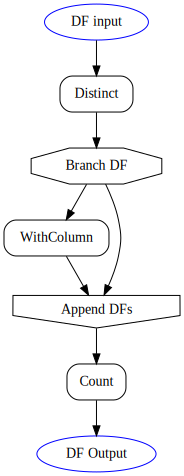

In [4]:
yml_data = """
pipeline:
  - pipeline:
      - transformer: Distinct

  - branch:
      "end": "append"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "c1"
          value: "c"

  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** from storage
- **Output:** append

*** TransformerPipeline *** (3 transformers)
*** TransformerPipeline *** (1 transformers)
 - Distinct
------ BRANCH ------ {'end': 'append'}
    Input storage key: df_x
    *** TransformerPipeline *** (1 transformers)
     - WithColumn -> PARAMS: column_name="c1", value="c"
 - Count


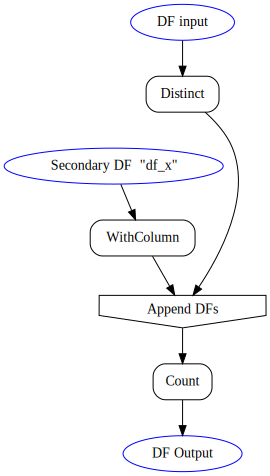

In [5]:
yml_data = """
pipeline:
  - pipeline:
      - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "append"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "c1"
          value: "c"

  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** join

*** TransformerPipeline *** (4 transformers)
 - Distinct
------ BRANCH ------ {'end': 'join', 'on': 'idx', 'how': 'inner'}
    *** TransformerPipeline *** (2 transformers)
     - DropColumns -> PARAMS: columns=['c1', 'c2']
     - WithColumn -> PARAMS: column_name="new", value=-1
*** TransformerPipeline *** (1 transformers)
 - Count


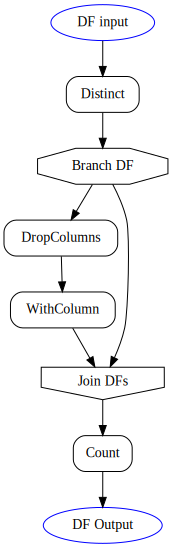

In [6]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "end": "join"
      "on": "idx"
      "how": "inner"
    pipeline:
      - transformer: DropColumns
        params:
          columns: [ "c1", "c2" ]
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** from storage
- **Output:** join

*** TransformerPipeline *** (4 transformers)
 - Distinct
------ BRANCH ------ {'end': 'join', 'on': 'idx', 'how': 'inner'}
    Input storage key: df_x
    *** TransformerPipeline *** (2 transformers)
     - DropColumns -> PARAMS: columns=['c1', 'c2']
     - WithColumn -> PARAMS: column_name="new", value=-1
*** TransformerPipeline *** (1 transformers)
 - Count


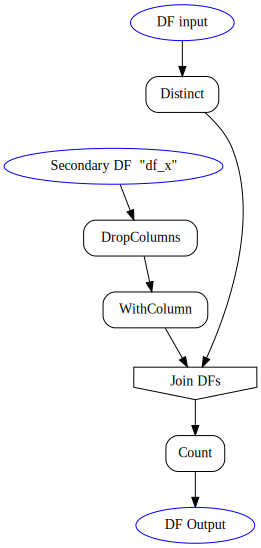

In [7]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "join"
      "on": "idx"
      "how": "inner"
    pipeline:
      - transformer: DropColumns
        params:
          columns: [ "c1", "c2" ]
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()